# Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, cross_val_predict,cross_validate,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

# PCA

In [ ]:
data = pd.read_csv('water_potability.csv')
data.fillna(data.median(), inplace=True)

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

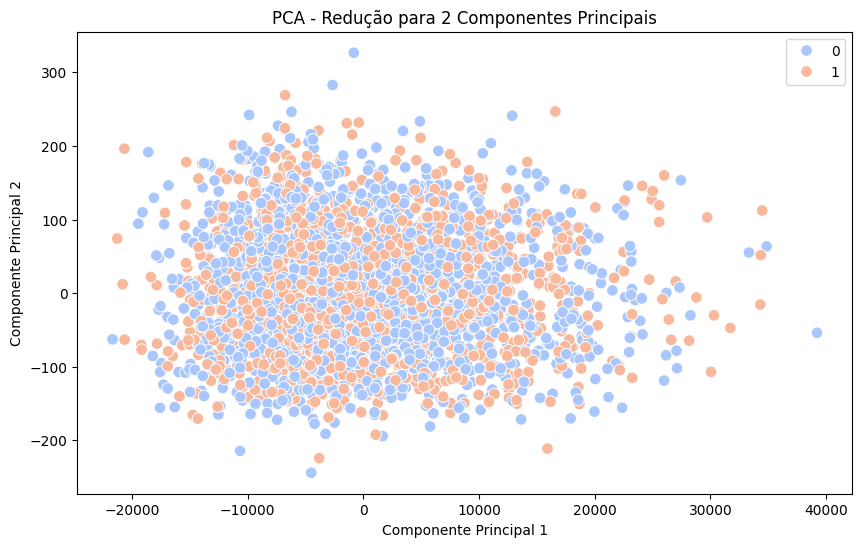

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', s=70)
plt.title('PCA - Redução para 2 Componentes Principais')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# Precisão

## Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [4, 6, 8, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

# Grid Search com 10-fold Nested Cross-Validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, scoring='precision', n_jobs=-1)
nested_scores = cross_val_score(grid_search, X_train, y_train, cv=10, scoring='precision')

print(f"Nested Cross-Validation Precision: {nested_scores.mean():.4f} ± {nested_scores.std():.4f}")

Nested Cross-Validation Precision: 0.6753 ± 0.0958


Accuracy: 0.6570
F1 Score: 0.2671
Recall: 0.1602
Precision: 0.8039
ROC AUC: 0.6580
PR AUC: 0.5874


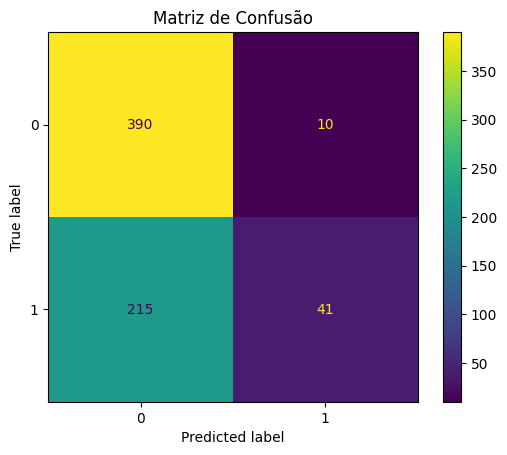

In [ ]:
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
print("Melhores hiperparâmetros encontrados pelo GridSearchCV:")
print(grid_search.best_params_)

Melhores hiperparâmetros encontrados pelo GridSearchCV:
{'classifier__criterion': 'entropy', 'classifier__max_depth': 8, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}


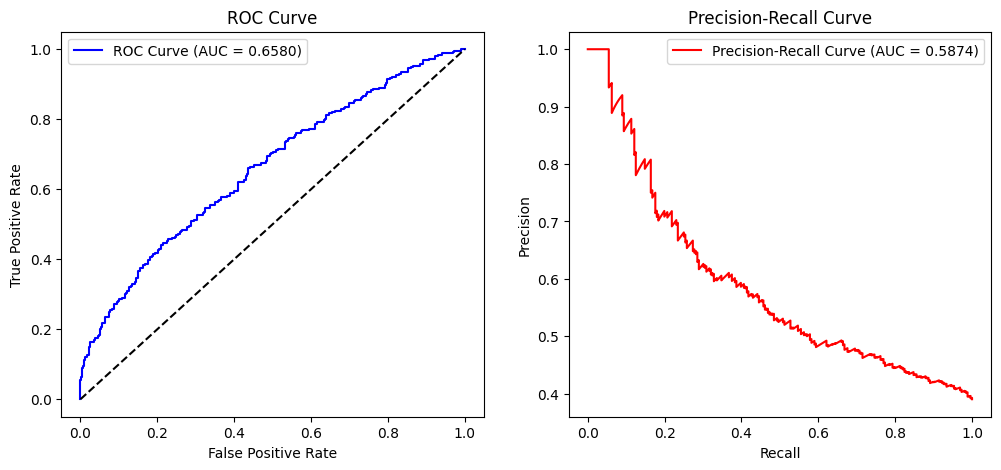

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='red', label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.show()

## MLP

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=2000))
])


param_grid = {
    'mlp__hidden_layer_sizes': [(5,), (10,), (15,), (5,5), (10, 10), (15, 15)],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.001, 0.01, 0.1],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.01, 0.1],
    'mlp__momentum': [0.5, 0.6, 0.7, 0.8, 0.9]}

# Grid Search com validação cruzada de 10 dobras
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, scoring='precision', n_jobs=-1)

# Avaliando com Nested Cross-Validation
nested_scores = cross_val_score(grid_search, X_train, y_train, cv=10, scoring='precision')

# Resultados
print(f"Nested Cross-Validation Precision: {nested_scores.mean():.4f} ± {nested_scores.std():.4f}")

Nested Cross-Validation Precision: 0.6115 ± 0.2365


Accuracy: 0.6677
F1 Score: 0.4140
Recall: 0.3008
Precision: 0.6638
ROC AUC: 0.6620
PR AUC: 0.6063


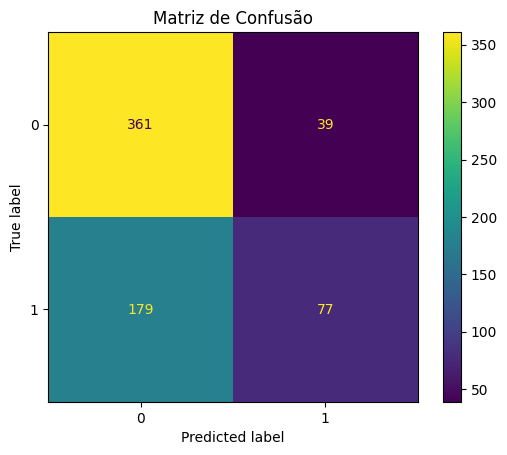

In [ ]:
grid_search.fit(X_train, y_train)
best_mlp = grid_search.best_estimator_

y_pred = best_mlp.predict(X_test)
y_pred_proba = best_mlp.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
print("Melhores hiperparâmetros encontrados pelo GridSearchCV:")
print(grid_search.best_params_)

Melhores hiperparâmetros encontrados pelo GridSearchCV:
{'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (10,), 'mlp__learning_rate': 'adaptive', 'mlp__learning_rate_init': 0.1, 'mlp__momentum': 0.8, 'mlp__solver': 'adam'}


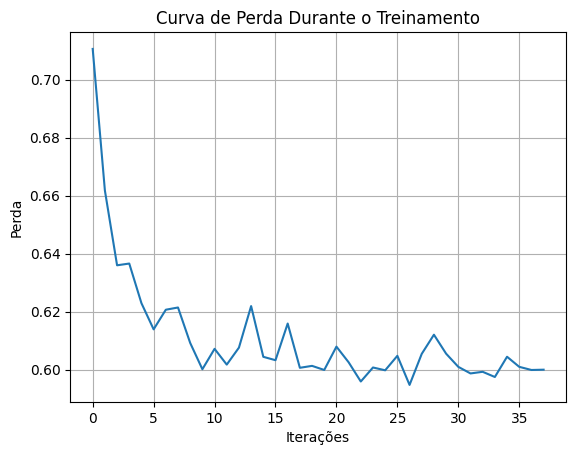

In [ ]:
mlp_classifier = best_mlp.named_steps['mlp']

plt.figure()
plt.plot(mlp_classifier.loss_curve_)
plt.title('Curva de Perda Durante o Treinamento')
plt.xlabel('Iterações')
plt.ylabel('Perda')
plt.grid(True)
plt.show()

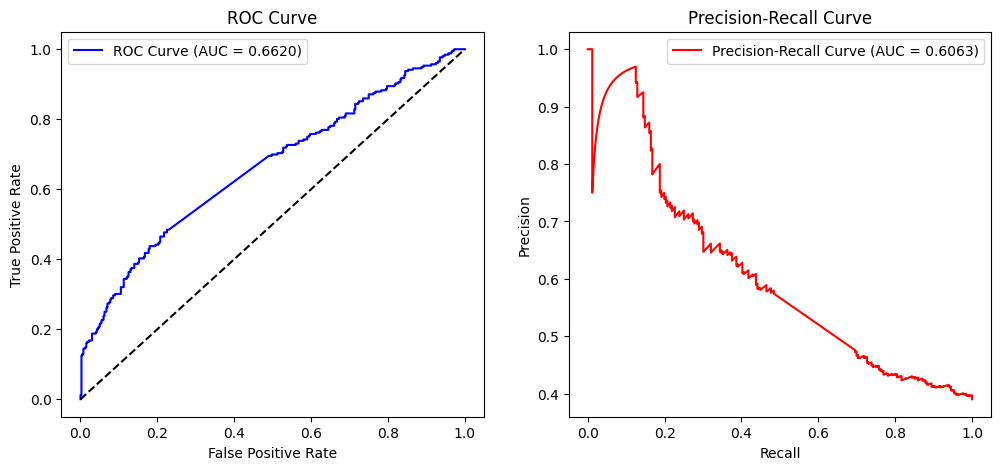

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='red', label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.show()

## SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

paramGrid = {
    'svm__C': [2**i for i in range(-5, 16)],
    'svm__gamma': [2**i for i in range(-15, 4)]
}

# Grid Search com validação cruzada de 10 dobras
gridSearch = GridSearchCV(estimator=pipeline, param_grid=paramGrid, cv=10, scoring='precision', n_jobs=-1)

# Avaliando com Nested Cross-Validation
nestedScores = cross_val_score(gridSearch, X_train, y_train, cv=10, scoring='precision')

# Resultados
print(f"Nested Cross-Validation Precision: {nestedScores.mean():.4f} ± {nestedScores.std():.4f}")


Nested Cross-Validation Precision: 0.7730 ± 0.2881


Accuracy: 0.6220
F1 Score: 0.0606
Recall: 0.0312
Precision: 1.0000
ROC AUC: 0.6718
PR AUC: 0.6019


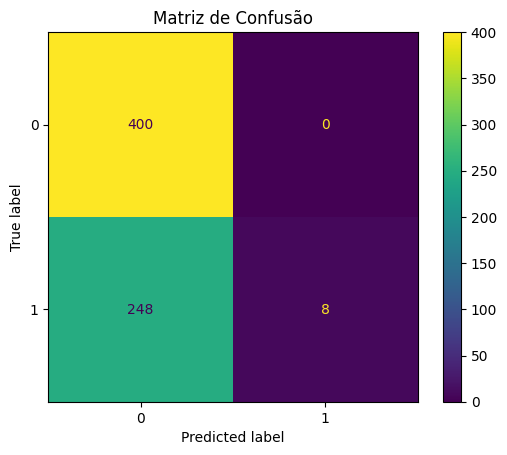

In [ ]:
gridSearch.fit(X_train, y_train)
best_svm = gridSearch.best_estimator_

y_pred = best_svm.predict(X_test)
y_pred_proba = best_svm.decision_function(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
print("Melhores hiperparâmetros encontrados pelo GridSearchCV:")
print(gridSearch.best_params_)

Melhores hiperparâmetros encontrados pelo GridSearchCV:
{'svm__C': 0.5, 'svm__gamma': 0.015625}


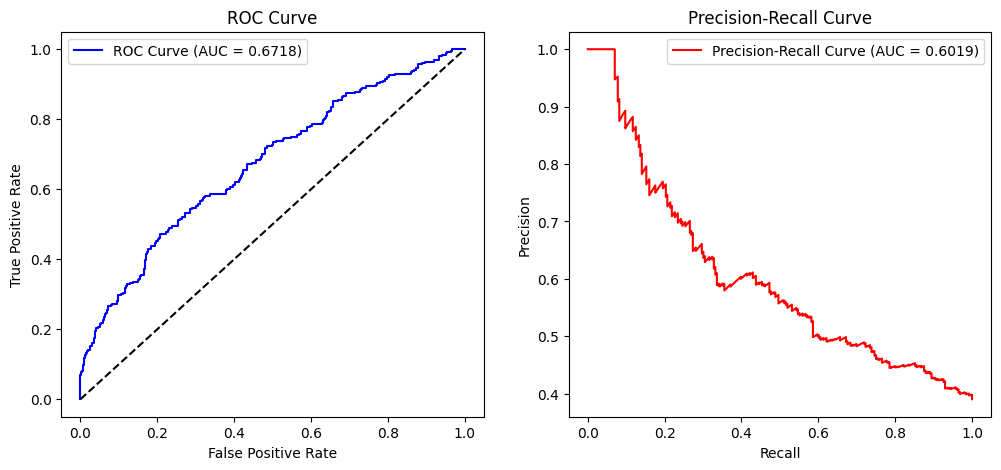

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='red', label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.show()

# F1-Score

## Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [4, 6, 8, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

# Grid Search com 10-fold Nested Cross-Validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)
nested_scores = cross_val_score(grid_search, X_train, y_train, cv=10, scoring='precision')

print(f"Nested Cross-Validation Precision: {nested_scores.mean():.4f} ± {nested_scores.std():.4f}")

Nested Cross-Validation Precision: 0.6292 ± 0.0533


Accuracy: 0.6662
F1 Score: 0.4341
Recall: 0.3281
Precision: 0.6412
ROC AUC: 0.6652
PR AUC: 0.5989


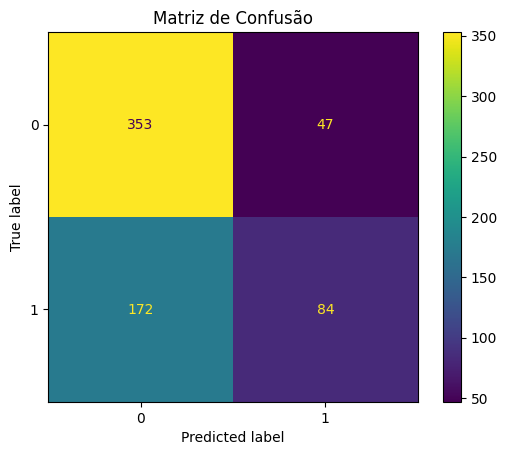

In [ ]:
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
print("Melhores hiperparâmetros encontrados pelo GridSearchCV:")
print(grid_search.best_params_)

Melhores hiperparâmetros encontrados pelo GridSearchCV:
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


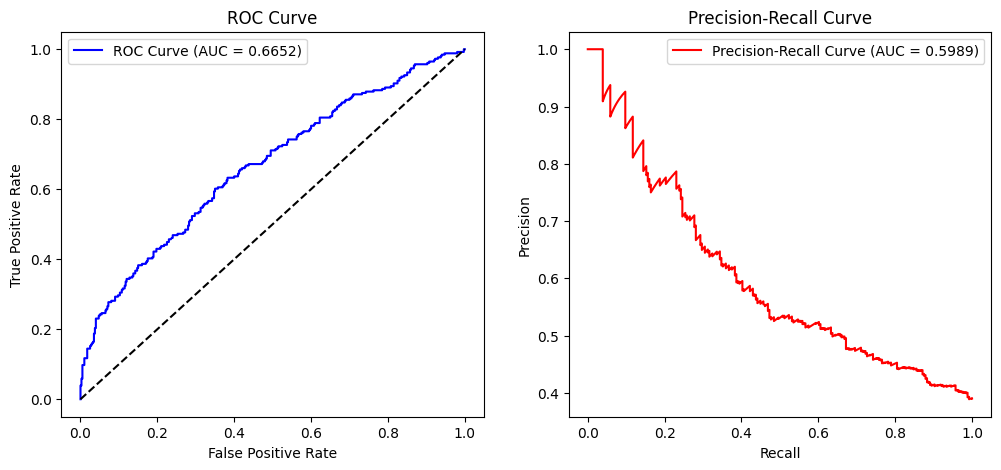

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='red', label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.show()

## MLP

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=2000))
])


param_grid = {
    'mlp__hidden_layer_sizes': [(5,), (10,), (15,), (5,5), (10, 10), (15, 15)],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.001, 0.01, 0.1],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.01, 0.1],
    'mlp__momentum': [0.5, 0.6, 0.7, 0.8, 0.9]}

# Grid Search com validação cruzada de 10 dobras
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

# Avaliando com Nested Cross-Validation
nested_scores = cross_val_score(grid_search, X_train, y_train, cv=10, scoring='precision')

# Resultados
print(f"Nested Cross-Validation Precision: {nested_scores.mean():.4f} ± {nested_scores.std():.4f}")

Nested Cross-Validation Precision: 0.5699 ± 0.0301


Accuracy: 0.6448
F1 Score: 0.4764
Recall: 0.4141
Precision: 0.5608
ROC AUC: 0.6183
PR AUC: 0.5481


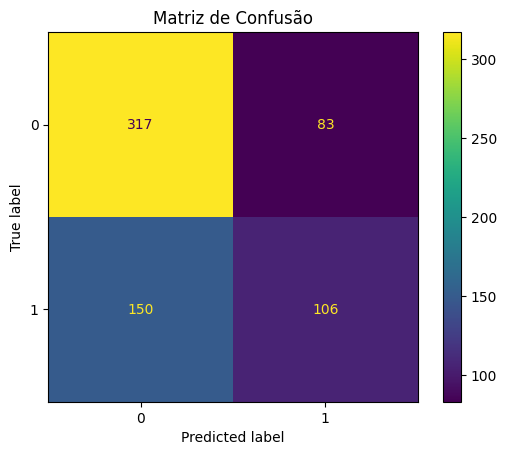

In [ ]:
grid_search.fit(X_train, y_train)
best_mlp = grid_search.best_estimator_

y_pred = best_mlp.predict(X_test)
y_pred_proba = best_mlp.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
print("Melhores hiperparâmetros encontrados pelo GridSearchCV:")
print(grid_search.best_params_)

Melhores hiperparâmetros encontrados pelo GridSearchCV:
{'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (15, 15), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.01, 'mlp__momentum': 0.7, 'mlp__solver': 'adam'}


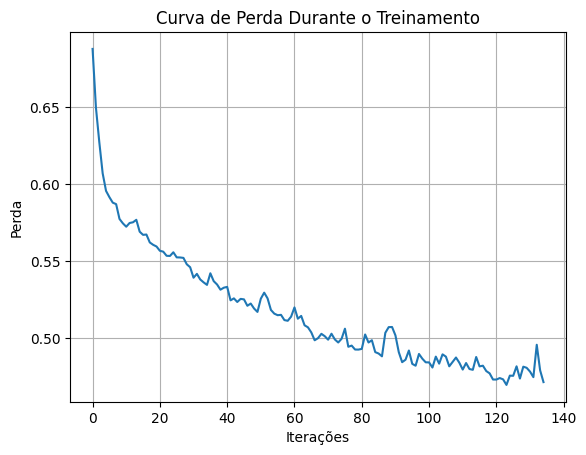

In [ ]:
# Acessando o MLPClassifier dentro do pipeline
mlp_classifier = best_mlp.named_steps['mlp']

# Plotando o gráfico de perda
plt.figure()
plt.plot(mlp_classifier.loss_curve_)
plt.title('Curva de Perda Durante o Treinamento')
plt.xlabel('Iterações')
plt.ylabel('Perda')
plt.grid(True)
plt.show()

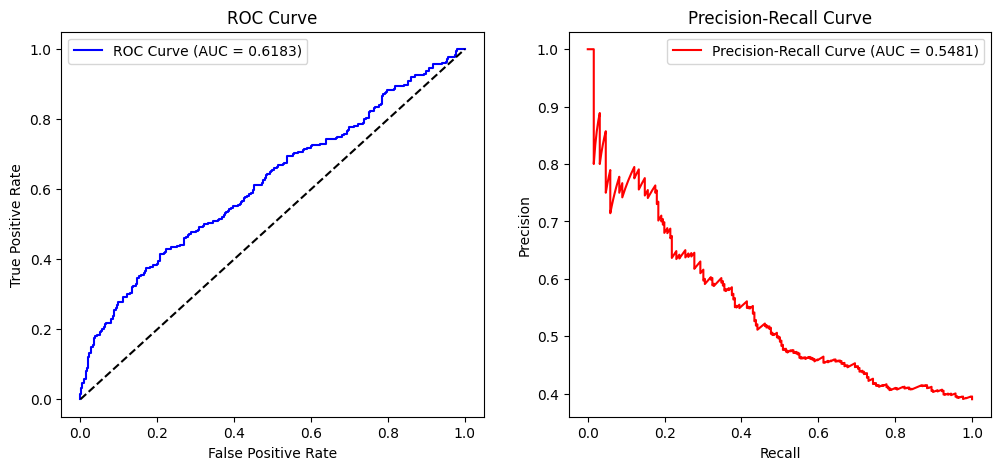

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='red', label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.show()

## SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

paramGrid = {
    'svm__C': [2**i for i in range(-5, 16)],
    'svm__gamma': [2**i for i in range(-15, 4)]
}

# Grid Search com validação cruzada de 10 dobras
gridSearch = GridSearchCV(estimator=pipeline, param_grid=paramGrid, cv=10, scoring='f1', n_jobs=-1)

# Avaliando com Nested Cross-Validation
nestedScores = cross_val_score(gridSearch, X_train, y_train, cv=10, scoring='precision')

# Resultados
print(f"Nested Cross-Validation Precision: {nestedScores.mean():.4f} ± {nestedScores.std():.4f}")


Nested Cross-Validation Precision: 0.5749 ± 0.0536


Accuracy: 0.5976
F1 Score: 0.4081
Recall: 0.3555
Precision: 0.4789
ROC AUC: 0.5945
PR AUC: 0.5090


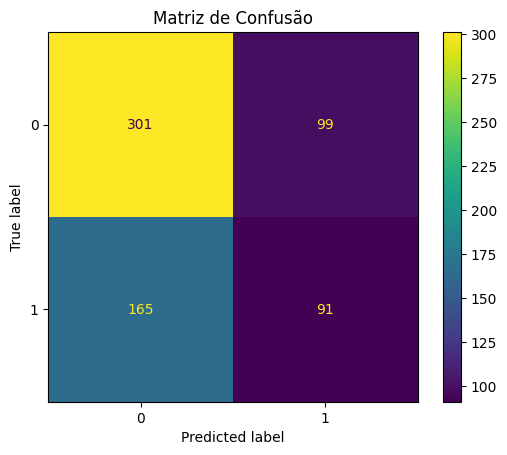

In [ ]:
gridSearch.fit(X_train, y_train)
best_svm = gridSearch.best_estimator_

y_pred = best_svm.predict(X_test)
y_pred_proba = best_svm.decision_function(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
print("Melhores hiperparâmetros encontrados pelo GridSearchCV:")
print(gridSearch.best_params_)

Melhores hiperparâmetros encontrados pelo GridSearchCV:
{'svm__C': 4096, 'svm__gamma': 0.03125}


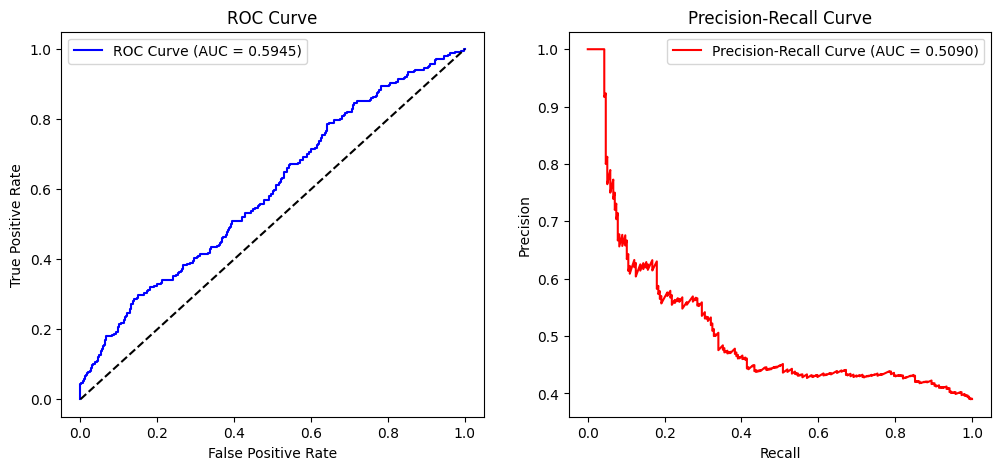

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='red', label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.show()